### **Aditya Badave (240340128001)**

### **Parth Dasawant (240340128007)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, r2_score
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC, SVR
from sklearn.linear_model import ElasticNet, LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaseEnsemble, VotingClassifier, GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, StackingClassifier, StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r'..\Kaggle\Tabular\train.csv', parse_dates=['time'])
test = pd.read_csv(r'..\Kaggle\Tabular\test.csv', parse_dates=['time'])
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


In [3]:
# Parsing the Datetime

train['year']=train['time'].dt.year
train['month']=train['time'].dt.month
train['day']=train['time'].dt.day
train['hour']=train['time'].dt.hour
train["weekday"] = train["time"].dt.weekday

train.head()

,row_id,time,x,y,direction,congestion,year,month,day,hour,weekday
0,0,1991-04-01,0,0,EB,70,1991,4,1,0,0
1,1,1991-04-01,0,0,NB,49,1991,4,1,0,0
2,2,1991-04-01,0,0,SB,24,1991,4,1,0,0
3,3,1991-04-01,0,1,EB,18,1991,4,1,0,0
4,4,1991-04-01,0,1,NB,60,1991,4,1,0,0


In [4]:
test['year']=test['time'].dt.year
test['month']=test['time'].dt.month
test['day']=test['time'].dt.day
test['hour']=test['time'].dt.hour
test["weekday"] = test["time"].dt.weekday

test.head()

,row_id,time,x,y,direction,year,month,day,hour,weekday
0,848835,1991-09-30 12:00:00,0,0,EB,1991,9,30,12,0
1,848836,1991-09-30 12:00:00,0,0,NB,1991,9,30,12,0
2,848837,1991-09-30 12:00:00,0,0,SB,1991,9,30,12,0
3,848838,1991-09-30 12:00:00,0,1,EB,1991,9,30,12,0
4,848839,1991-09-30 12:00:00,0,1,NB,1991,9,30,12,0


In [5]:
# Applying Label Encoder for 'direction' column

le = LabelEncoder()
direction = le.fit_transform(train['direction'])
direction = pd.DataFrame(direction,columns=['direction'])

df1 = pd.concat([train,direction], axis=1)
df1.head()

,row_id,time,x,y,direction,congestion,year,month,day,hour,weekday,direction
0,0,1991-04-01,0,0,EB,70,1991,4,1,0,0,0
1,1,1991-04-01,0,0,NB,49,1991,4,1,0,0,1
2,2,1991-04-01,0,0,SB,24,1991,4,1,0,0,4
3,3,1991-04-01,0,1,EB,18,1991,4,1,0,0,0
4,4,1991-04-01,0,1,NB,60,1991,4,1,0,0,1


In [6]:
le = LabelEncoder()
direction = le.fit_transform(test['direction'])
direction = pd.DataFrame(direction,columns=['direction'])

df2 = pd.concat([test,direction], axis=1)
df2.head()

,row_id,time,x,y,direction,year,month,day,hour,weekday,direction
0,848835,1991-09-30 12:00:00,0,0,EB,1991,9,30,12,0,0
1,848836,1991-09-30 12:00:00,0,0,NB,1991,9,30,12,0,1
2,848837,1991-09-30 12:00:00,0,0,SB,1991,9,30,12,0,4
3,848838,1991-09-30 12:00:00,0,1,EB,1991,9,30,12,0,0
4,848839,1991-09-30 12:00:00,0,1,NB,1991,9,30,12,0,1


In [7]:
X_train = df1.drop(columns=['row_id', 'congestion', 'time','direction'])
y_train = df1['congestion']
X_test = df2.drop(columns=['row_id','time','direction'])

# Transforming the target variable as log response variable
# As normal log function is giving -infinity at some places, hence we will use log1p as it calculates log(1 + x).
y_train_log = np.log1p(y_train)
y_train_log.unique()

array([4.26267988, 3.91202301, 3.21887582, 2.94443898, 4.11087386,
       4.07753744, 3.29583687, 3.4657359 , 3.8501476 , 3.40119738,
       2.83321334, 3.09104245, 3.87120101, 3.95124372, 4.31748811,
       3.78418963, 3.80666249, 3.97029191, 3.49650756, 4.35670883,
       3.68887945, 4.15888308, 3.98898405, 3.36729583, 4.00733319,
       3.73766962, 3.63758616, 2.77258872, 4.12713439, 4.18965474,
       3.13549422, 3.55534806, 3.8286414 , 3.76120012, 3.93182563,
       3.61091791, 4.17438727, 3.4339872 , 4.02535169, 4.06044301,
       3.71357207, 3.52636052, 2.89037176, 3.8918203 , 4.27666612,
       4.24849524, 2.39789527, 4.21950771, 4.39444915, 4.52178858,
       3.58351894, 4.04305127, 4.09434456, 3.66356165, 4.36944785,
       3.33220451, 4.38202663, 3.04452244, 4.4308168 , 4.14313473,
       3.25809654, 2.99573227, 2.07944154, 4.41884061, 4.33073334,
       4.34380542, 4.4543473 , 4.61512052, 1.09861229, 4.48863637,
       2.56494936, 4.49980967, 4.30406509, 2.48490665, 4.40671

In [8]:
lr=LinearRegression()
lr.fit(X_train,y_train_log)
# 'expm1', calculate exp(x) - 1 for all elements in the array.
y_pred=np.expm1(lr.predict(X_test))

submit = pd.DataFrame({'row_id':test['row_id'],
                       'congestion':y_pred})
submit.to_csv("LR.csv", index=False)

In [9]:
elastic=ElasticNet()
elastic.fit(X_train,y_train_log)
y_pred=np.expm1(elastic.predict(X_test))

submit = pd.DataFrame({'row_id':test['row_id'],
                       'congestion':y_pred})
submit.to_csv("ElasticNet.csv", index=False)

In [10]:
xgboost = XGBRegressor(random_state=24)
xgboost.fit(X_train,y_train_log)
y_pred=np.expm1(xgboost.predict(X_test))

submit = pd.DataFrame({'row_id':test['row_id'],
                       'congestion':y_pred})
submit.to_csv("XGBoost.csv", index=False)

In [11]:
cat = CatBoostRegressor(random_state=24)
cat.fit(X_train,y_train_log)
y_pred=np.expm1(cat.predict(X_test))

submit = pd.DataFrame({'row_id':test['row_id'],
                       'congestion':y_pred})
submit.to_csv("CatBoost.csv", index=False)

Learning rate set to 0.118832
0:	learn: 0.4068418	total: 205ms	remaining: 3m 24s
1:	learn: 0.4012297	total: 250ms	remaining: 2m 4s
2:	learn: 0.3968173	total: 295ms	remaining: 1m 38s
3:	learn: 0.3933555	total: 340ms	remaining: 1m 24s
4:	learn: 0.3914293	total: 382ms	remaining: 1m 15s
5:	learn: 0.3897746	total: 426ms	remaining: 1m 10s
6:	learn: 0.3876127	total: 471ms	remaining: 1m 6s
7:	learn: 0.3864197	total: 517ms	remaining: 1m 4s
8:	learn: 0.3847905	total: 559ms	remaining: 1m 1s
9:	learn: 0.3834394	total: 604ms	remaining: 59.8s
10:	learn: 0.3827186	total: 646ms	remaining: 58.1s
11:	learn: 0.3820488	total: 691ms	remaining: 56.9s
12:	learn: 0.3812655	total: 735ms	remaining: 55.8s
13:	learn: 0.3807760	total: 781ms	remaining: 55s
14:	learn: 0.3799953	total: 830ms	remaining: 54.5s
15:	learn: 0.3794378	total: 879ms	remaining: 54s
16:	learn: 0.3791155	total: 924ms	remaining: 53.5s
17:	learn: 0.3786508	total: 972ms	remaining: 53s
18:	learn: 0.3783991	total: 1.02s	remaining: 52.5s
19:	learn: 0

In [12]:
lgbm = LGBMRegressor(random_state=24)
lgbm.fit(X_train,y_train_log)
y_pred=np.expm1(lgbm.predict(X_test))

submit = pd.DataFrame({'row_id':test['row_id'],
                       'congestion':y_pred})
submit.to_csv("LGBM.csv", index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 848835, number of used features: 6
[LightGBM] [Info] Start training from score 3.815882


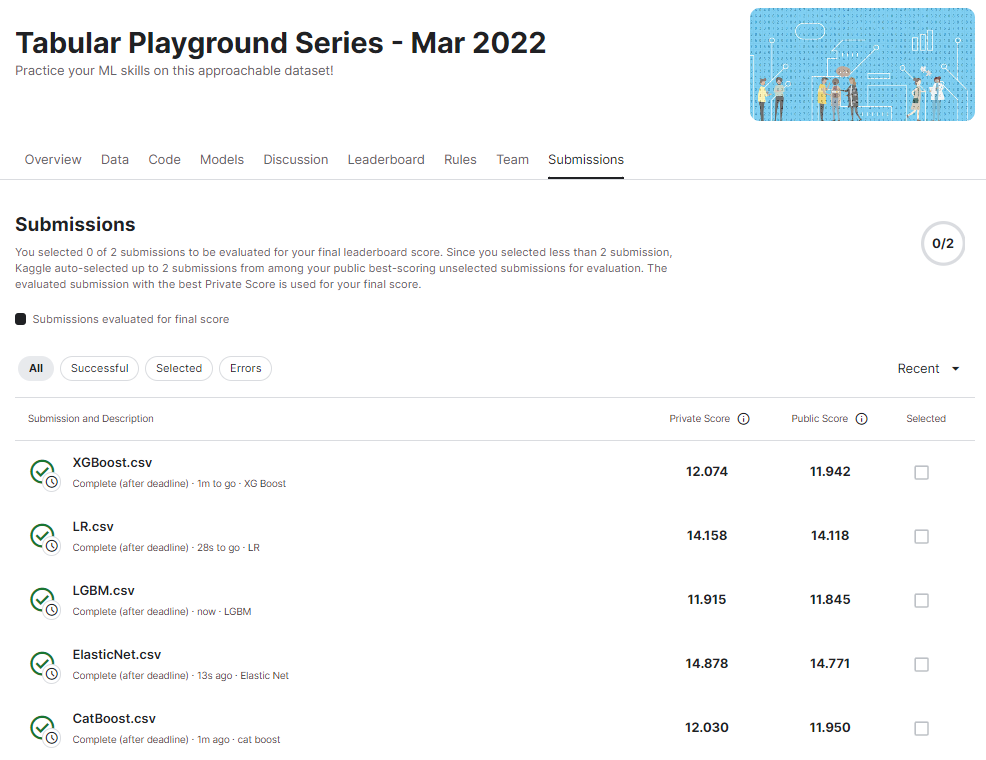